In [1]:
#Dependencies are imported at the start to perform statistical analyses on the data available via SQLite, which is accessed 
#through the SQLAlchemy extension. Matplotlib allows for visuals to support the analysis.

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, text, inspect, func

In [2]:
# Connect to sqlite by creating engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Use the inspector tool via SQLAlchemy to analyze tables available in the SQLite doc and columns in each table
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Use automap to map database into classes & check that tables were mapped
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save the mapped tables to Python objects
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Once we are ready to start querying the data, we can start the session
session = Session(engine)

In [13]:
# Find most recent date & arrange in decending order, find first()
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

In [14]:
# Grab one year worth of data from the most recent date:
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save to dataframe and name columns
df = pd.DataFrame(prev_year_results, columns=['date', 'precipitation'])

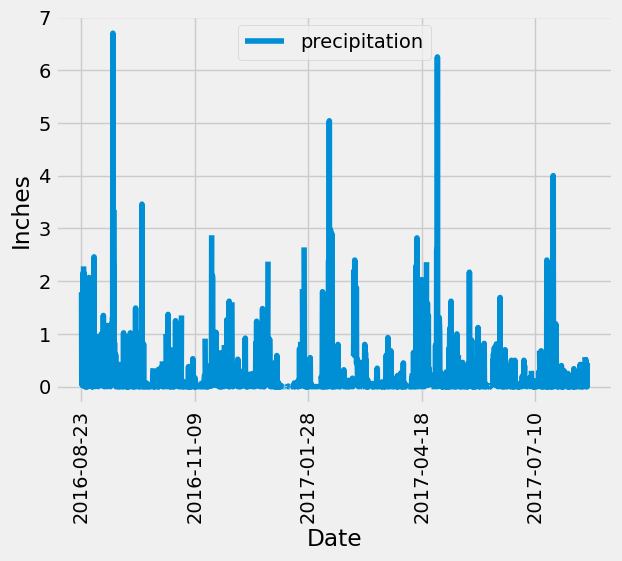

In [20]:
#Plot daily rainfall data with Matplotlib:
df = df.sort_values("date")
df.plot(x='date', y='precipitation', rot=90)
#plt.figure(figsize=(10,4))
plt.xlabel("Date")
plt.ylabel("Inches")
#plt.bar(df["date"],df["precipitation"]) --> initially tried this method but found issues with date size

plt.show()

In [27]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
#Count the number of stations:
number_of_stations = session.query(func.count(Station.station)).all()
print("% sstations were measured in this analysis" %number_of_stations)

[(9,)]stations were measured in this analysis


In [30]:
# Count number of stations
session.query(func.count(Station.station)).all()

[(9,)]

In [32]:
# Sorting stations by activity level, most rainfall to least rainfall
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Calculating the lowest, highest, and average temperature based on most active station.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

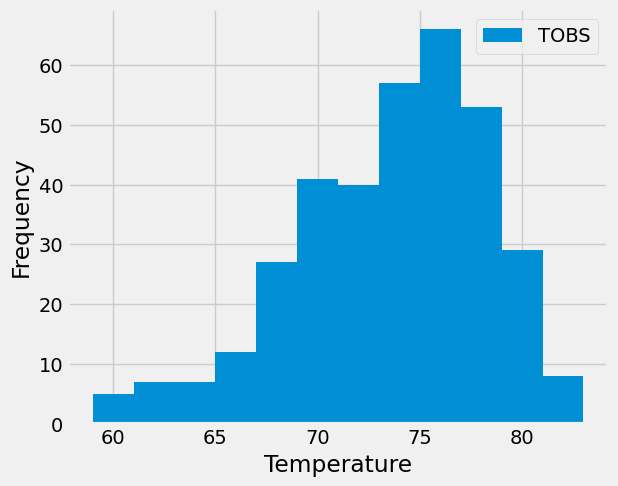

In [36]:
# Last 12 months of temperature for the most active station
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['TOBS'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

plt.show()

In [37]:
# Close session once the analysis is done
session.close()